In [1]:
import hats_import
from hats_import.catalog.arguments import ImportArguments
from dask.distributed import Client
from hats_import.pipeline import pipeline_with_client
import glob
import lsdb
from upath import UPath
import upath
import astropy.units as u
import numpy as np
import pyarrow.feather as feather
import pandas as pd

In [2]:
# for gaia import
from pathlib import Path
from astropy.io import ascii
import dask.array
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from hats import read_hats
from hats.inspection import plot_pixels
# and margin caches
from hats_import.catalog.file_readers import CsvReader
from hats_import.margin_cache.margin_cache_arguments import MarginCacheArguments
from hats_import.pipeline import ImportArguments, pipeline_with_client

from shutil import copyfileobj
import requests  # For downloading files

### Initialize Dask

In [3]:
client = Client(n_workers=4)

### Load the meta (.feather file) for one f=795 file

In [4]:
ztf_feather = feather.read_table('ztf_dr23/t_795_zr_c01_o_q1/meta_ztf_20180321399988_000795_zr_c01_o_q1_psfcat.feather')

In [5]:
ztf_feather['ra'][0].as_py(), ztf_feather['dec'][0].as_py()

(251.95110951, 52.39603125)

### Load 5 deg gaia cone search catalog (empty margin cache)

In [6]:
"""open catalog from web with 5 deg cone search""" 
# gaia = lsdb.open_catalog(
#     "https://data.lsdb.io/hats/gaia_dr3/gaia",
#     # margin_cache="https://data.lsdb.io/hats/gaia_dr3/gaia_10arcs",
#     columns=["source_id", "ra", "dec", "parallax"],
#     search_filter=lsdb.ConeSearch(ra=ztf_feather['ra'][0].as_py(), dec=ztf_feather['dec'][0].as_py(), radius_arcsec=5 * 3600), # 3600 arcsec = 1 degree
# )
# gaia.to_hats("output/gaia_5deg_conesearch_fitsreader3") 
gaia = lsdb.open_catalog("output/gaia_5deg_conesearch_fitsreader3")
# *worked but local version has gaia.margin == None
print(gaia.margin == None)
gaia

True


,source_id,ra,dec,parallax
npartitions=1,,,,
"Order: 2, Pixel: 39",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]


In [7]:
gaia_lsdb = lsdb.open_catalog(
    "https://data.lsdb.io/hats/gaia_dr3/gaia",
    margin_cache="https://data.lsdb.io/hats/gaia_dr3/gaia_10arcs",
    columns=["source_id", "ra", "dec", "parallax", "phot_g_mean_mag"],
    search_filter=lsdb.ConeSearch(ra=ztf_feather['ra'][0].as_py(), dec=ztf_feather['dec'][0].as_py(), radius_arcsec=5 * 3600), # 3600 arcsec = 1 degree
)
# margin is empty, i.e gaia_lsdb.margin.head() has 0 rows

## Load ztf catalog (field 795)

In [8]:
ztf_f795 = lsdb.open_catalog("output/TEST_ZTFFitsReader_2_all")
print(len(ztf_f795))
ztf_f795.head()

12169415


,field,obsjd,rcid,expid,MAGZP,sourceid,xpos,ypos,ra,dec,flux,sigflux,mag,sigmag,snr,chi,sharp,flags
_healpix_29,,,,,,,,,,,,,,,,,,
706640038511694154,795,2458655.701157,0,90120115,26.026057,5976,462.752991,3065.052002,252.416743,51.854129,148.744644,28.166969,-5.431,0.206,5.28,0.911,-0.041,0
706640111120364455,795,2458655.685984,0,90118598,26.024383,2851,554.098999,3053.181885,252.371079,51.858007,160.958694,34.00819,-5.517,0.229,4.73,0.598,0.034,0
706640111301357200,795,2458655.701157,0,90120115,26.026057,5972,563.877014,3059.444092,252.371097,51.858123,123.70636,20.645523,-5.231,0.181,5.99,0.407,-0.095,0
706640130168008622,795,2458655.720891,0,90122089,26.019688,3592,465.303009,3067.528076,252.415799,51.854609,153.489319,49.592205,-5.465,0.351,3.1,1.158,-0.193,0
706640138273791634,795,2458660.745509,0,90624550,26.036355,10795,471.709991,3077.006104,252.406545,51.859292,44.980431,13.112123,-4.133,0.317,3.43,0.45,-0.01,0


In [9]:
np.mean(np.array(ztf_f795['flags'])==0) # fraction of flags that are equal to 0

np.float64(0.9819840148437702)

## crossmatch ztf field with gaia

In [10]:
ztf_suffix = '_ZTFFitsReader_2_all'
# xmatched_field = ztf_f795.crossmatch(
#     gaia,
#     radius_arcsec=0.2,
#     # Single closest object, it is the default
#     n_neighbors=1,
#     # Default would be to use names of the HATS catalogs
#     suffixes=(ztf_suffix, "_gaia"),
# )
# # ! C:\Users\lupin\OneDrive\Desktop\LINCC\lsdb\src\lsdb\dask\crossmatch_catalog_data.py:147: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate. warnings.warn(
# xmatched_field.to_hats(UPath("crossmatches/ZTFFitsReader_2_all_gaia_dr3"))
xmatched_field = lsdb.open_catalog(UPath("crossmatches/ZTFFitsReader_2_all_gaia_dr3"))
xmatched_field.head()

,field_ZTFFitsReader_2_all,obsjd_ZTFFitsReader_2_all,rcid_ZTFFitsReader_2_all,expid_ZTFFitsReader_2_all,MAGZP_ZTFFitsReader_2_all,sourceid_ZTFFitsReader_2_all,xpos_ZTFFitsReader_2_all,ypos_ZTFFitsReader_2_all,ra_ZTFFitsReader_2_all,dec_ZTFFitsReader_2_all,flux_ZTFFitsReader_2_all,sigflux_ZTFFitsReader_2_all,mag_ZTFFitsReader_2_all,sigmag_ZTFFitsReader_2_all,snr_ZTFFitsReader_2_all,chi_ZTFFitsReader_2_all,sharp_ZTFFitsReader_2_all,flags_ZTFFitsReader_2_all,source_id_gaia,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,
706640169304510594,795,2458658.744028,0,90424402,26.012071,9353,446.315002,3033.846924,252.420336,51.873811,1776.558105,196.843338,-8.124,0.12,9.03,4.154,0.423,0,1413280330443295360,252.420336,51.87386,<NA>,0.174167
706640169304574635,795,2458381.642824,0,62714282,26.078714,5274,350.131989,3065.657959,252.420367,51.873834,1824.78479,146.051865,-8.153,0.087,12.49,3.058,0.386,0,1413280330443295360,252.420336,51.87386,<NA>,0.114651
706640169304756151,795,2459140.623924,0,138612392,26.055817,7390,484.187988,3047.854004,252.420398,51.873851,2031.104248,260.029541,-8.269,0.139,7.81,4.528,0.458,0,1413280330443295360,252.420336,51.87386,<NA>,0.140783
706640169307426523,795,2458660.745509,0,90624550,26.036355,9329,446.066986,3022.938965,252.420273,51.873826,1823.10022,190.582092,-8.152,0.114,9.57,3.203,0.409,0,1413280330443295360,252.420336,51.87386,<NA>,0.185745
706640169307831687,795,2458387.639016,0,63313901,26.071061,5197,352.683014,3055.75708,252.420272,51.87386,1793.042725,188.92627,-8.134,0.114,9.49,3.99,0.384,0,1413280330443295360,252.420336,51.87386,<NA>,0.142378


## crossmatch plots

### set up indices and ra, dec region

In [11]:
# ra/dec np arrays for gaia, xmatch, and ztf catalogs
ra_gaia = np.array(gaia['ra'])
xmatched_ra_gaia = np.array(xmatched_field['ra_gaia'])
dec_gaia = np.array(gaia['dec'])
xmatched_dec_gaia = np.array(xmatched_field['dec_gaia'])
ra_ztf = np.array(ztf_f795['ra'])
xmatched_ra_ztf = np.array(xmatched_field['ra'+ztf_suffix])
dec_ztf = np.array(ztf_f795['dec'])
xmatched_dec_ztf = np.array(xmatched_field['dec'+ztf_suffix])

# small region to zoom in on
min_ra, max_ra = 251.45, 251.5
min_dec, max_dec = 52.05, 52.1
# np index into gaia columns for a small area between min/max ra and dec
gaia_idx = np.where((min_ra < ra_gaia) & 
                    (ra_gaia < max_ra) & 
                    (min_dec < dec_gaia) & 
                    (dec_gaia <  max_dec))[0]
# np index into xmatch columns for a small area between min/max ra and dec (using ra_/dec_gaia)
x_idx = np.where((min_ra < xmatched_ra_gaia) & 
                 (xmatched_ra_gaia < max_ra) & 
                 (min_dec < xmatched_dec_gaia) & 
                 (xmatched_dec_gaia <  max_dec))[0]
# np index into ztf columns for a small area between min/max ra and dec
ztf_idx = np.where((min_ra < ra_ztf) & 
                   (ra_ztf < max_ra) & 
                   (min_dec < dec_ztf) & 
                   (dec_ztf <  max_dec))[0]


# np index into ztf columns within a small area for rows that pass our filter
filtered_ztf_idx = np.intersect1d(ztf_idx, 
                                  np.where((np.array(ztf_f795['flags']) == 0) & 
                                           (np.array(ztf_f795['sigmag']) < 0.1))[0])

# np index into xmatch columns within a small area for rows that pass our filter
filtered_xmatch_idx = np.intersect1d(x_idx, 
                                     np.where((np.array(xmatched_field['flags'+ztf_suffix]) == 0) & 
                                              (np.array(xmatched_field['sigmag'+ztf_suffix]) < 0.1))[0])

In [12]:
print("num xmatch objects LTE num ztf objects in the small patch:")
print(len(x_idx), "<=", len(ztf_idx))
print("num gaia objects in small patch:", len(gaia_idx))

num xmatch objects LTE num ztf objects in the small patch:
11102 <= 24268
num gaia objects in small patch: 9


In [13]:
print("num xmatch objects LTE num ztf objects in the filtered, small patch:")
print(len(filtered_xmatch_idx), "<", len(filtered_ztf_idx))

num xmatch objects LTE num ztf objects in the filtered, small patch:
10085 < 11128


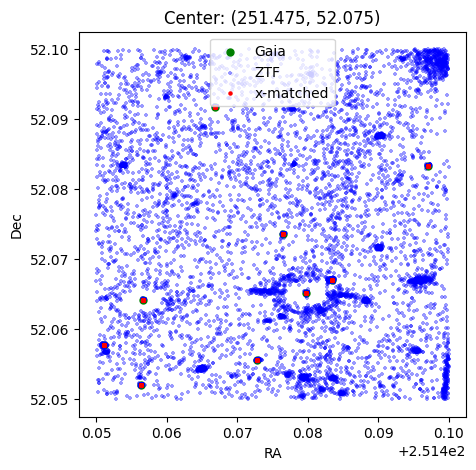

In [14]:
plt.figure(figsize=(5, 5))
plt.scatter(ra_gaia[gaia_idx], dec_gaia[gaia_idx], s=25, alpha=1.0, color="green", label="Gaia")
plt.scatter(ra_ztf[ztf_idx], dec_ztf[ztf_idx], s=5, alpha=0.4, marker="+", color="blue", label="ZTF")
plt.scatter(xmatched_ra_gaia[x_idx], xmatched_dec_gaia[x_idx], s=5, alpha=1.0, color="red", label="x-matched")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.legend()
plt.title(f"Center: ({min_ra+(max_ra-min_ra)/2}, {min_dec+(max_dec-min_dec)/2})")
plt.show()

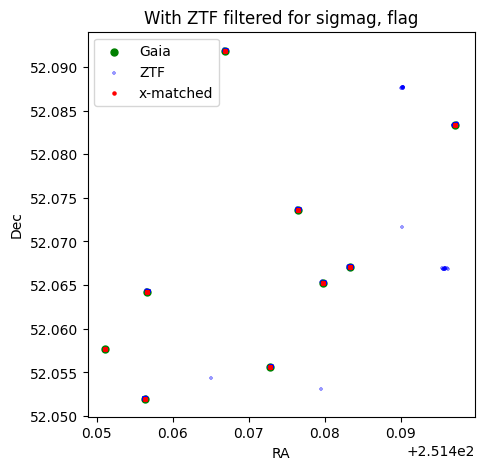

In [15]:
plt.figure(figsize=(5, 5))
plt.scatter(ra_gaia[gaia_idx], dec_gaia[gaia_idx], s=25, alpha=1.0, color="green", label="Gaia")
plt.scatter(ra_ztf[filtered_ztf_idx], dec_ztf[filtered_ztf_idx], s=5, alpha=0.4, marker="+", color="blue", label="ZTF")
plt.scatter(xmatched_ra_gaia[x_idx], xmatched_dec_gaia[x_idx], s=5, alpha=1.0, color="red", label="x-matched")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title("With ZTF filtered for sigmag, flag")
plt.legend()
plt.show()

In [16]:
expid_colname = 'expid' + ztf_suffix
sourceid_colname = 'source_id_gaia'
print("number of unique ztf expids in xmatch:", len(np.unique(np.array(xmatched_field[expid_colname]))))
print("number of unique gaia sourceids in xmatch:", len(np.unique(np.array(xmatched_field[sourceid_colname]))))

number of unique ztf expids in xmatch: 1688
number of unique gaia sourceids in xmatch: 5635


In [17]:
len(xmatched_field), len(ztf_idx), len(gaia_idx)

(4462741, 24268, 9)

### histograms

#### source/exposure IDs

9 gaia objs in this region


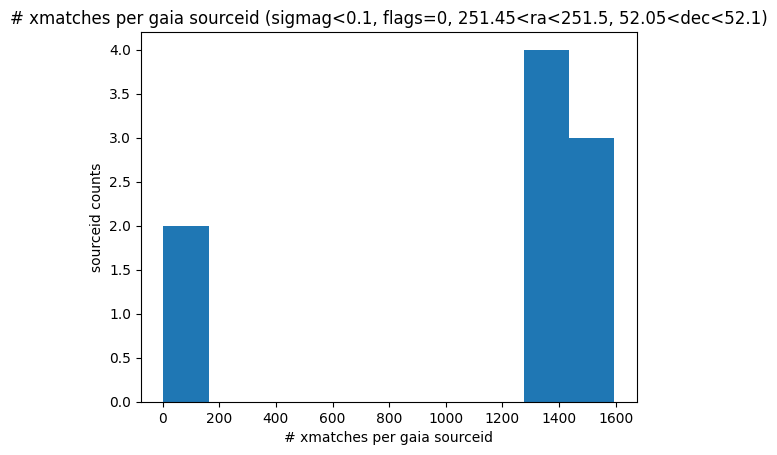

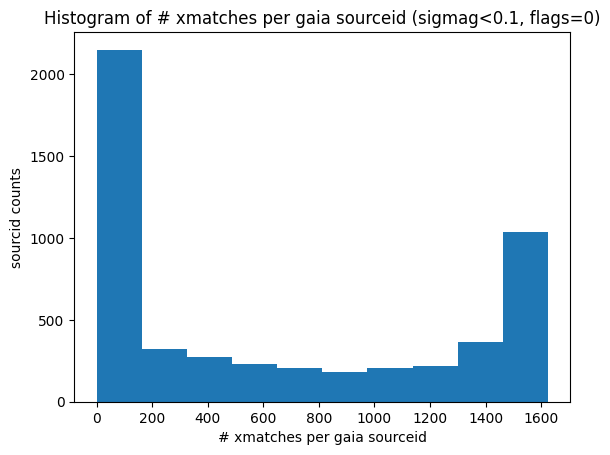

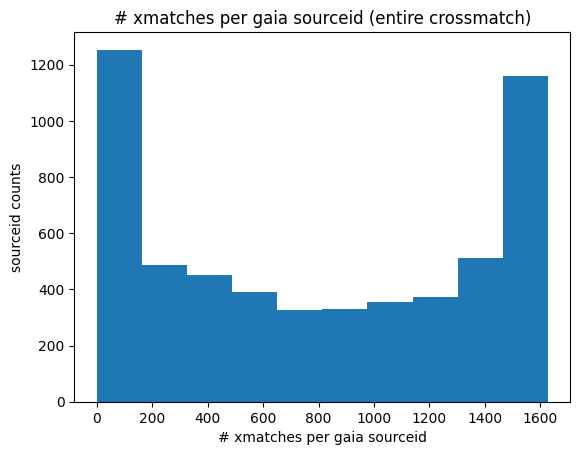

In [18]:
# small region, filtered ZTF for 'good' entries
filtered_sourceid_groups = {}
sourceids = np.array(xmatched_field['source_id_gaia'])
for sourceid in np.unique(sourceids[filtered_xmatch_idx]):
    idx = np.intersect1d(np.where((sourceids == sourceid))[0], filtered_xmatch_idx)
    filtered_sourceid_groups[sourceid] = idx # dictionary keys=sourceids, values=indices into columns of xmatched_field
print(len(np.array(gaia['source_id'])[gaia_idx]), "gaia objs in this region")
assert(np.sum([len(filtered_sourceid_groups[sourceid]) for sourceid in filtered_sourceid_groups]) == len(filtered_xmatch_idx))
plt.hist([len(filtered_sourceid_groups[sourceid]) for sourceid in filtered_sourceid_groups])
plt.title("# xmatches per gaia sourceid (sigmag<0.1, flags=0, 251.45<ra<251.5, 52.05<dec<52.1)")
plt.xlabel("# xmatches per gaia sourceid")
plt.ylabel("sourceid counts")
plt.show()
[len(filtered_sourceid_groups[sourceid]) for sourceid in filtered_sourceid_groups]


# entire crossmatch, filter ztf for 'good' entries
sourceid_groups = {}
filter_all_idx = np.where((np.array(xmatched_field['flags'+ztf_suffix]) == 0) & 
                          (np.array(xmatched_field['sigmag'+ztf_suffix]) < 0.1))[0]
sourceids = np.array(xmatched_field[sourceid_colname])[filter_all_idx]
for sourceid in np.unique(sourceids):
    idx = np.where(sourceids == sourceid)[0]
    sourceid_groups[sourceid] = idx # dictionary keys=sourceids, values=indices into columns of xmatched_field

assert(np.sum([len(sourceid_groups[sourceid]) for sourceid in sourceid_groups])==len(filter_all_idx))
plt.hist([len(sourceid_groups[sourceid]) for sourceid in sourceid_groups])
plt.title("Histogram of # xmatches per gaia sourceid (sigmag<0.1, flags=0)")
plt.xlabel("# xmatches per gaia sourceid")
plt.ylabel("sourcid counts")
plt.show()

# entire crossmatch
sourceid_groups = {}
sourceids = np.array(xmatched_field[sourceid_colname])
for sourceid in np.unique(sourceids):
    idx = np.where(sourceids == sourceid)[0]
    sourceid_groups[sourceid] = idx # dictionary keys=sourceids, values=indices into columns of xmatched_field

assert(np.sum([len(sourceid_groups[sourceid]) for sourceid in sourceid_groups])==len(xmatched_field))
plt.hist([len(sourceid_groups[sourceid]) for sourceid in sourceid_groups])
plt.title("# xmatches per gaia sourceid (entire crossmatch)")
plt.xlabel("# xmatches per gaia sourceid")
plt.ylabel("sourceid counts")
plt.show()

In [19]:
len(xmatched_field), len(filter_all_idx)

(4462741, 3290480)

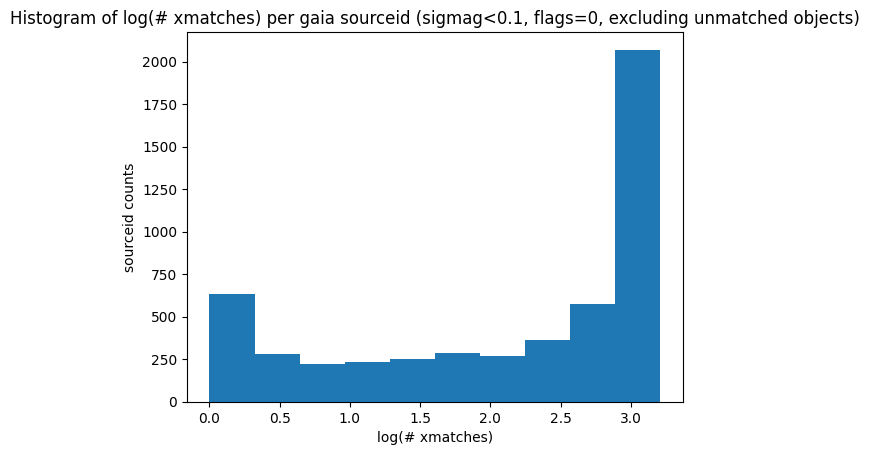

In [20]:
sourceid_groups = {}
filter_all_idx = np.where((np.array(xmatched_field['flags'+ztf_suffix]) == 0) & 
                          (np.array(xmatched_field['sigmag'+ztf_suffix]) < 0.1))[0]
sourceids = np.array(xmatched_field[sourceid_colname])[filter_all_idx]
for sourceid in np.unique(sourceids):
    idx = np.where(sourceids == sourceid)[0]
    if len(idx) > 0:
        sourceid_groups[sourceid] = idx # dictionary keys=sourceids, values=indices into columns of xmatched_field

assert(np.sum([len(sourceid_groups[sourceid]) for sourceid in sourceid_groups])==len(filter_all_idx))
plt.hist(np.log10([len(sourceid_groups[sourceid]) for sourceid in sourceid_groups]))
plt.title("Histogram of log(# xmatches) per gaia sourceid (sigmag<0.1, flags=0, excluding unmatched objects)")
plt.xlabel("log(# xmatches)")
plt.ylabel("sourceid counts")
plt.show()

In [21]:
count_of_grouped_by_sourceid_expid = xmatched_field.map_partitions(
                            lambda x: 
                                   x.groupby(['source_id_gaia', 
                                              'expid_ZTFFitsReader_2_all']).count())
count_of_grouped_by_sourceid_expid.head()


field_ZTFFitsReader_2_all  \
source_id_gaia      expid_ZTFFitsReader_2_all                              
1413280326146372480 63315509                                           1   
                    63620152                                           1   
                    90336804                                           1   
                    90424402                                           1   
                    90624550                                           1   

                                               obsjd_ZTFFitsReader_2_all  \
source_id_gaia      expid_ZTFFitsReader_2_all                              
1413280326146372480 63315509                                           1   
                    63620152                                           1   
                    90336804                                           1   
                    90424402                                           1   
                    90624550                                           1   

                                               rcid_ZTFFitsReader_2_all  \
source_id_gaia      expid_ZTFFitsReader_2_all                             
1413280326146372480 63315509                                          1   
                    63620152                                          1   
                    90336804                                          1   
                    90424402                                          1   
                    90624550                                          1   

                                               MAGZP_ZTFFitsReader_2_all  \
source_id_gaia      expid_ZTFFitsReader_2_all                              
1413280326146372480 63315509                                           1   
                    63620152                                           1   
                    90336804                                           1   
                    90424402                                           1   
                    90624550                                           1   

                                               sourceid_ZTFFitsReader_2_all  \
source_id_gaia      expid_ZTFFitsReader_2_all                                 
1413280326146372480 63315509                                              1   
                    63620152                                              1   
                    90336804                                              1   
                    90424402                                              1   
                    90624550                                              1   

                                               xpos_ZTFFitsReader_2_all  \
source_id_gaia      expid_ZTFFitsReader_2_all                             
1413280326146372480 63315509                                          1   
                    63620152                                          1   
                    90336804                                          1   
                    90424402                                          1   
                    90624550                                          1   

                                               ypos_ZTFFitsReader_2_all  \
source_id_gaia      expid_ZTFFitsReader_2_all                             
1413280326146372480 63315509                                          1   
                    63620152                                          1   
                    90336804                                          1   
                    90424402                                          1   
                    90624550                                          1   

                                               ra_ZTFFitsReader_2_all  \
source_id_gaia      expid_ZTFFitsReader_2_all                           
1413280326146372480 63315509                                        1   
                    63620152                                        1   
                    9033

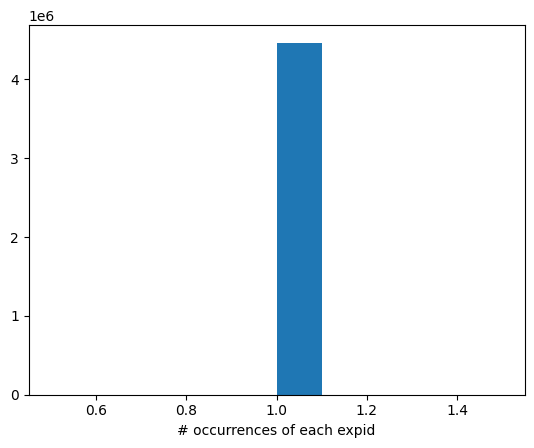

n=array([      0.,       0.,       0.,       0.,       0., 4462741.,
             0.,       0.,       0.,       0.])
bins=array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5])


In [22]:
n, bins, patches = plt.hist(np.array(count_of_grouped_by_sourceid_expid['field_ZTFFitsReader_2_all']))
plt.xlabel("# occurrences of each expid")
plt.show()
print(f"{n=}")
print(f"{bins=}")

In [23]:
# all xmatches accounted for in groupby (n is values of bins)
assert(np.sum(n) == len(xmatched_field))

#### phot_g_mean_mag of gaia

In [24]:
# load idx into gaia cone searched catalog of xmatched objects

# matched_gaia_idx = np.isin(np.array(gaia_lsdb['source_id']), np.unique(np.array(xmatched_field['source_id_gaia'])))
# * index into gaia cone search for rows that show up in the crossmatch w/ ZTFFitsReader_2_all
# np.save("matched_gaia_idx", matched_gaia_idx)
matched_gaia_idx = np.load("matched_gaia_idx.npy")
assert(np.sum(matched_gaia_idx) + np.sum(np.logical_not(matched_gaia_idx)) == matched_gaia_idx.shape)


# get their mags
gaia_phot_g_mean_mag = (gaia_lsdb['phot_g_mean_mag']).to_dask_array(lengths=True).compute()
gaia_phot_g_mean_mag_arr = np.array([np.nan if (x is pd.NA or x is None) else x for x in gaia_phot_g_mean_mag], dtype=float)
assert(matched_gaia_idx.shape == gaia_phot_g_mean_mag_arr.shape)

c:\Users\lupin\lsdb_m25\lib\site-packages\dask\dataframe\dask_expr\_collection.py:1430: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting float[pyarrow] to object dtype.
  warnings.warn(


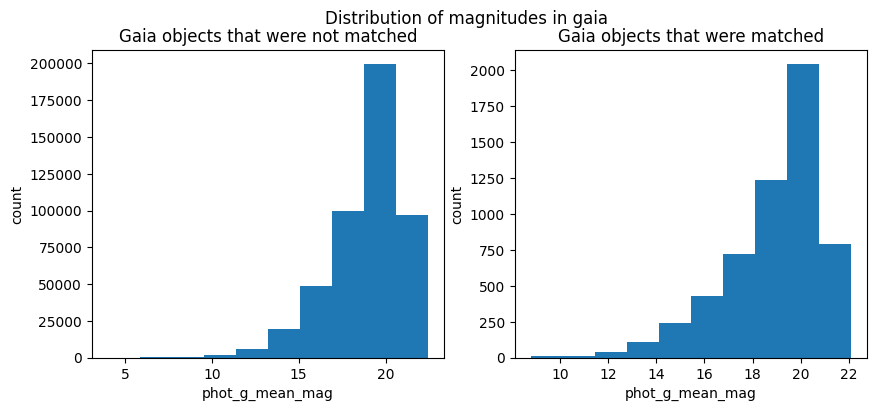

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.suptitle("Distribution of magnitudes in gaia")
# idx1 = np.intersect1d(gaia_idx, np.where(np.logical_not(matched_gaia_idx))[0])
ax[0].hist(gaia_phot_g_mean_mag_arr[np.logical_not(matched_gaia_idx)])
ax[0].set_title("Gaia objects that were not matched")
ax[0].set_xlabel("phot_g_mean_mag")
ax[0].set_ylabel("count")

# idx2 = np.intersect1d(gaia_idx, np.where(matched_gaia_idx)[0])
ax[1].hist(gaia_phot_g_mean_mag_arr[matched_gaia_idx])
ax[1].set_title("Gaia objects that were matched")
ax[1].set_xlabel("phot_g_mean_mag")
ax[1].set_ylabel("count")
plt.show()

#### calibrated magnitude of ZTF

In [26]:
# get indices of xmatches into the original ZTF catalog
ztf_f795_mcal_arr = np.array(ztf_f795['MAGZP']) + np.array(ztf_f795['mag'])
matched_ztf_f795_idx = np.isin(np.array(ztf_f795['sourceid']), np.unique(np.array(xmatched_field['sourceid_ZTFFitsReader_2_all'])))
assert(len(ztf_f795) == len(matched_ztf_f795_idx))

## Close Dask client

In [28]:
client.close()

2025-07-27 16:55:38,162 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-07-27 16:55:38,204 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-07-27 16:55:38,209 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-07-27 16:55:38,214 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing


In [29]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Status: closed,Using processes: True
Comm: tcp://127.0.0.1:54602,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: 12 minutes ago,Total memory: 0 B
